#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [1]:
# libs initialization
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sp
import pylab

from math import inf
from prettytable import PrettyTable
from sklearn.decomposition import PCA

In [2]:
# Dataset initialization
path_to_file = '../Datasets/Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')
# source_df.columns = ["V"+str(i) for i in range(1, len(source_df.columns)+1)]  # rename column names to be similar to R naming convention
# source_df.V2 = source_df.V2.astype(str)
source_df.head(7)

,Unnamed: 0,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,0,4247263043,22.050000,0,1,0,0,0,0,0,...,68,73.016,49.832,533,64,12.8,138,8,38.711,60.463
1,1,4247155821,21.950000,1,0,0,0,1,0,2,...,8,44.218,37.136,571,59,11.8,134,3,24.829,14.105
2,2,4243963257,15.533333,0,0,0,0,0,0,0,...,20,30.797,35.364,400,50,10.0,89,5,12.589,45.201
3,3,4241678498,34.966667,0,0,0,1,1,0,1,...,72,125.866,70.528,832,84,16.8,205,9,65.312,88.202
4,4,4241538868,39.066667,1,1,1,1,1,1,2,...,83,131.536,74.596,794,85,17.0,227,7,86.431,64.141
5,5,4241394461,26.116667,1,1,1,0,0,1,2,...,34,64.242,44.280,555,61,12.2,140,3,23.741,20.132
6,6,4233222221,28.100000,0,0,1,0,0,0,0,...,59,78.424,58.032,640,73,14.6,214,5,31.415,61.040


In [3]:
# Colums renaming and data preparation
source_df = source_df[['gameDuraton', # this is the value we will predict (target)
                        'blueWins', # this is our category sorter
                        'blueWardPlaced', # all other values are the predictors
                        'blueWardkills', 
                        'blueKills', 
                        'blueDeath', 
                        'blueChampionDamageDealt', 
                        'blueTotalGold', 
                        'blueTotalMinionKills', 
                        'blueJungleMinionKills',
                        'blueTotalHeal',
                        'blueObjectDamageDealt']]

# show new dataset
source_df.head(7)


,gameDuraton,blueWins,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt
0,22.050000,0,38,13,15,31,56.039,37.001,440,105,31.035,5.675
1,21.950000,1,57,18,19,8,60.243,41.072,531,111,26.397,45.303
2,15.533333,0,28,7,5,20,24.014,22.929,306,64,6.567,5.651
3,34.966667,0,129,39,26,36,101.607,63.447,774,226,24.718,31.019
4,39.066667,1,114,35,27,40,134.826,74.955,831,252,37.161,95.287
5,26.116667,1,65,23,26,18,59.839,52.221,576,171,40.925,51.855
6,28.100000,0,72,26,16,31,70.270,47.107,601,136,20.503,31.788


In [4]:
# plt.figure(figsize=(13, 8))

# kernel = scipy.stats.gaussian_kde(source_df['game_length'])

# min_amount, max_amount = source_df['game_length'].min(), source_df['game_length'].max()
# x = np.linspace(min_amount, max_amount, len(source_df)) # by defaul 50 items
# kde_values = kernel(x)

# # sns.histplot(source_df[col_name], kde=False, stat="density", label=f'Average transaction size in rubles')
# # Draw unnormed histogramm
# hist_data = plt.hist(source_df['game_length'], density=True, bins=50)

# # print(hist_vals)
# plt.plot(x, kde_values, color="r")

# plt.ylabel('p')
# plt.xlabel('Average transaction size')

# plt.legend()
# plt.show()

## Used variables explanation
> Here is a very brief summary of the values ​​used. 
> Details are contained in the [README.MD](https://github.com/vandosik/M-M-MSA/blob/master/Datasets/README.MD) file in the datasets folder.
1. gameDuraton: This value indicates the duration of the match and is the main investigated value in the second laboratory work. It is calculated as the difference between the start and end timestamps of the match.
2. blueWins: An integer number of wins for the blue team.
3. blueWardPlaced: Ward is a special item in the game that is used to increase the visibility of the game card.
4. blueWardkills: Ward is a special item in the game that is used to increase the visibility of the game card.
5. blueKills: Blue team kills.
6. blueDeath: Blue team deaths.
7. blueChampionDamageDealt: The sum of units of damage inflicted on opponents.
8. blueTotalGold: The amount of in-game currency earned by the team.
9. blueTotalMinionKills: Number of NPCs killed by the blue team.
10. blueJungleMinionKills: Number of Jungle NPCs killed by the blue team. 
11. blueTotalHeal: The amount of health earned by the team.
12. blueObjectDamageDealt: The sum of units of damage inflicted on enemy buildings.

## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

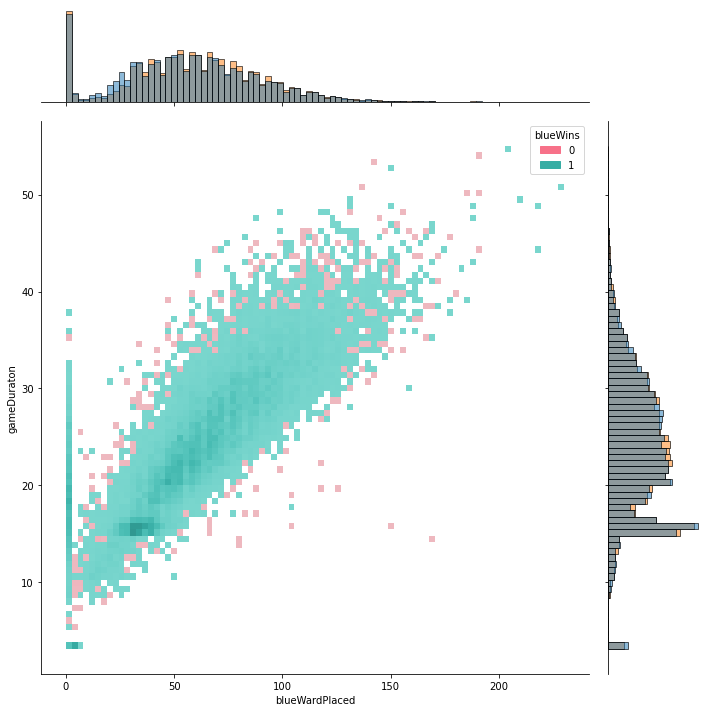

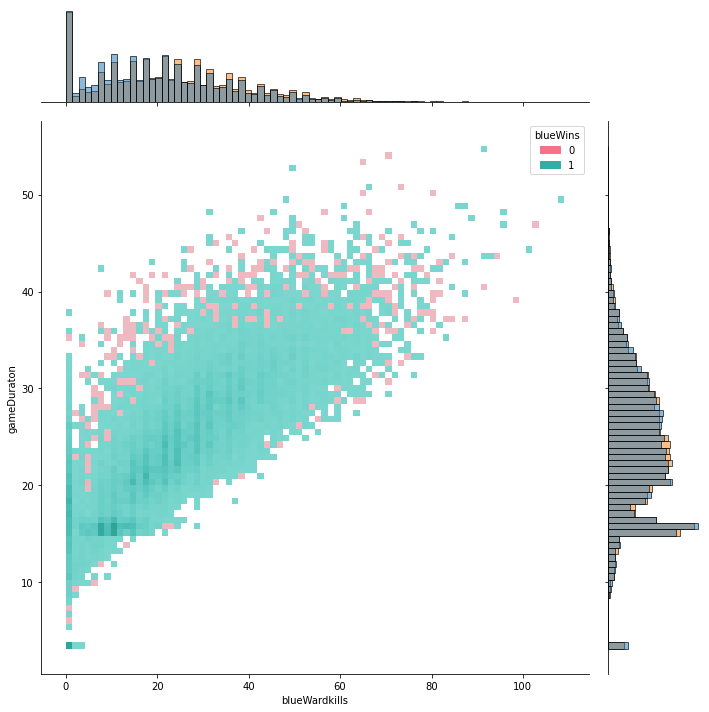

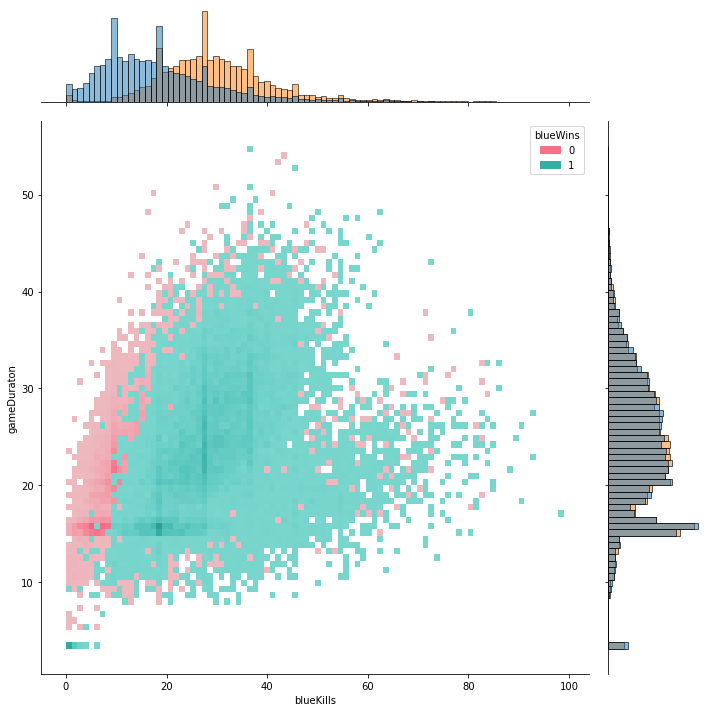

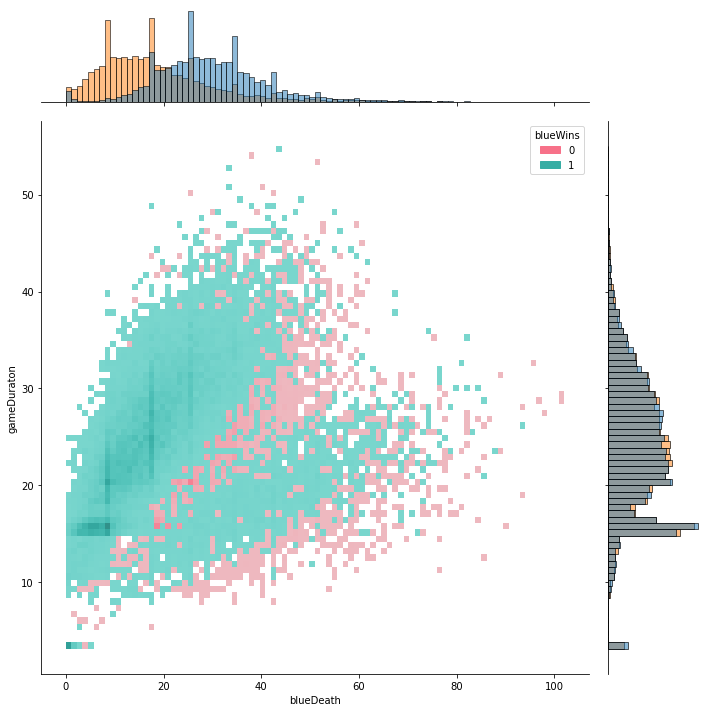

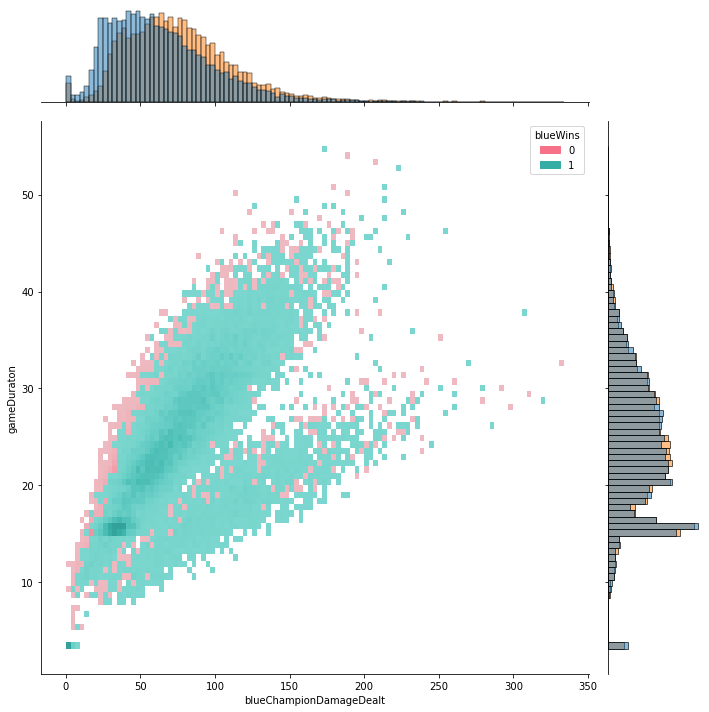

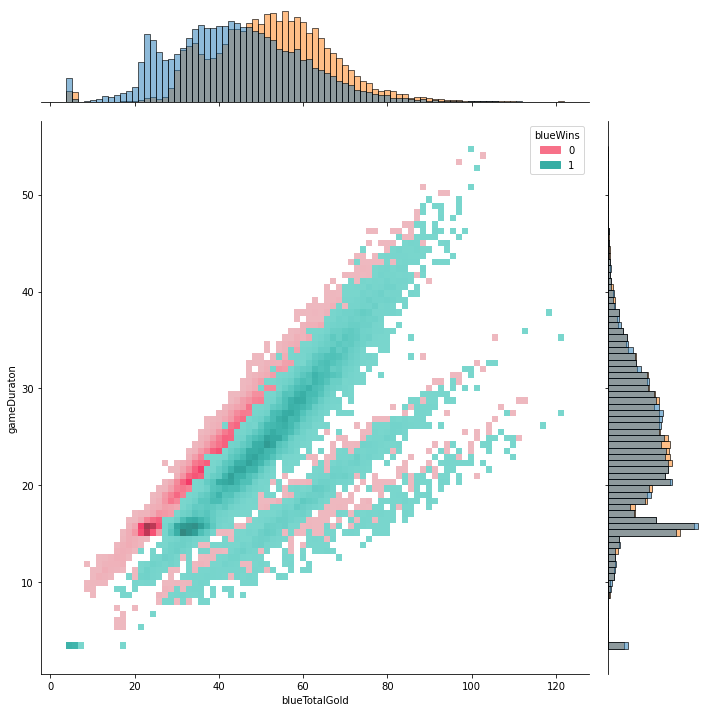

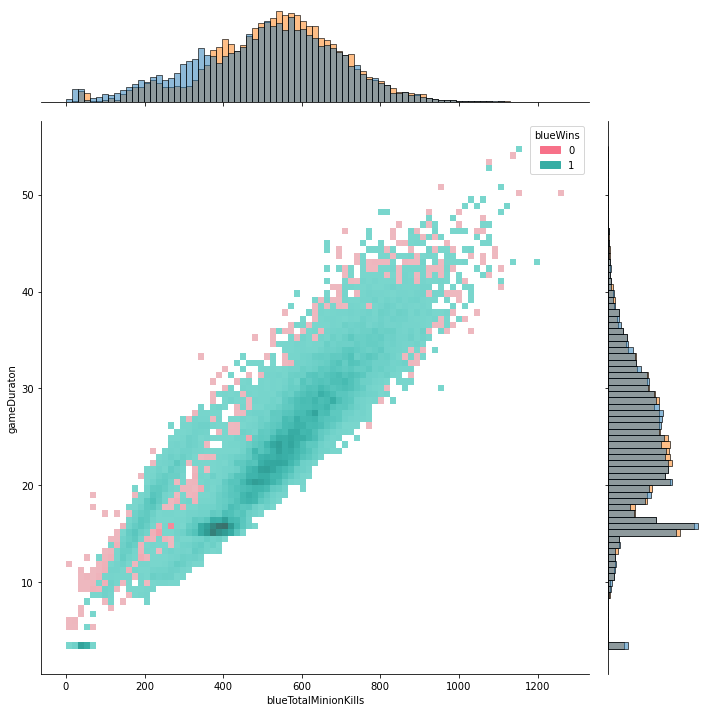

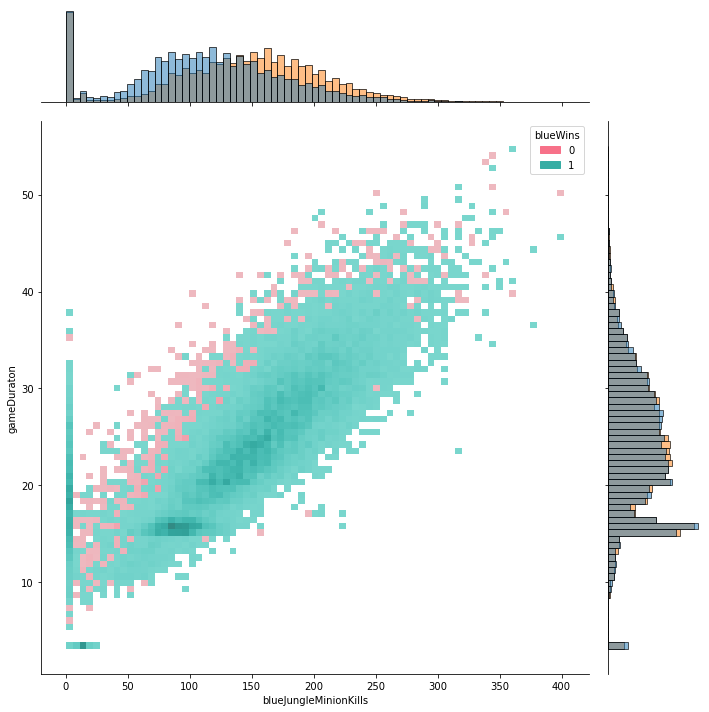

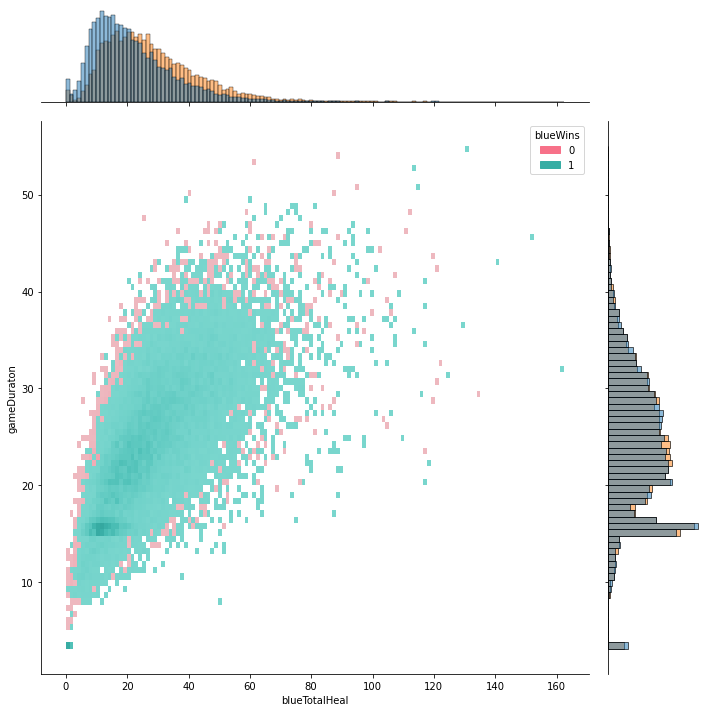

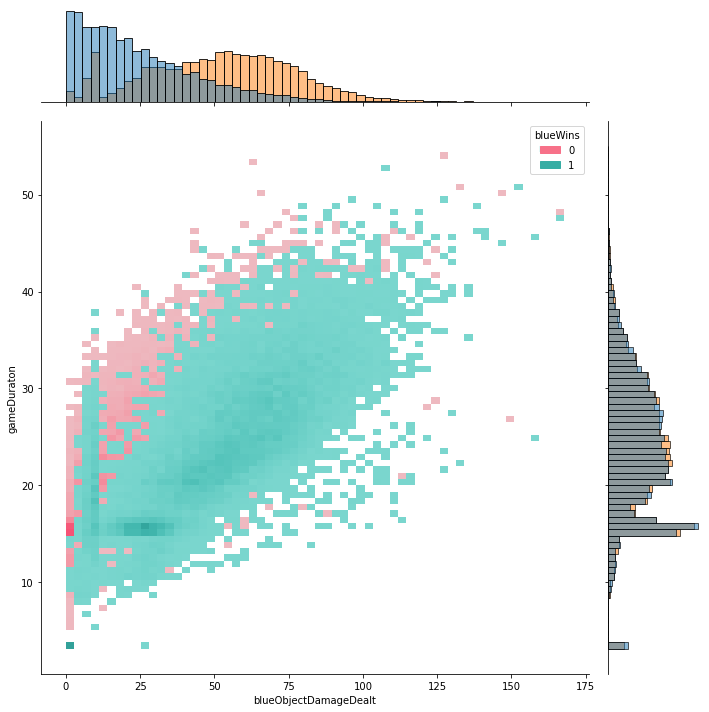

In [5]:
ilist = source_df.columns.tolist()
for i in range(2, len(ilist)):
    sns.jointplot(data=source_df, x=ilist[i], y='gameDuraton', hue='blueWins', height=10, kind="hist", palette="husl")
    

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

In [6]:
table = PrettyTable()
table.field_names = ["Column name", "mathematical expectation", "variance"]
for i in range(0, len(ilist)-1):
    table.add_row([str(ilist[i]), str(source_df.mean()[i]), str(source_df.var()[i])])
print(table)

+-------------------------+--------------------------+---------------------+
|       Column name       | mathematical expectation |       variance      |
+-------------------------+--------------------------+---------------------+
|       gameDuraton       |    24.14422762414511     |  49.60321233051361  |
|         blueWins        |    0.5000743383883437    | 0.25000928711754167 |
|      blueWardPlaced     |    58.64035087719298     |  982.9231697241096  |
|      blueWardkills      |    22.330136782634554    |  240.32047448599184 |
|        blueKills        |    24.18941421349985     |  167.81358009025033 |
|        blueDeath        |    24.180567945286946    |  170.11615064943672 |
| blueChampionDamageDealt |     69.746341882248      |  1279.0189829913902 |
|      blueTotalGold      |    48.16912990633363     |  239.51386762751284 |
|   blueTotalMinionKills  |     520.446587867975     |  30965.83865170302  |
|  blueJungleMinionKills  |     129.586938745168     |  4181.303298898823  |

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

<Figure size 1800x1080 with 0 Axes>

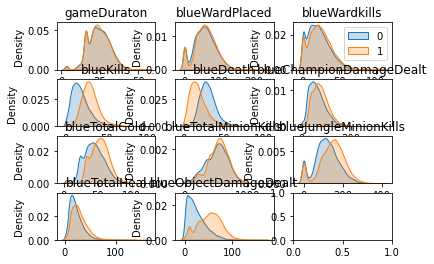

In [7]:
# list of variables without bluewins
w = ['gameDuraton',
    'blueWardPlaced',
    'blueWardkills', 
    'blueKills', 
    'blueDeath', 
    'blueChampionDamageDealt', 
    'blueTotalGold', 
    'blueTotalMinionKills', 
    'blueJungleMinionKills',
    'blueTotalHeal',
    'blueObjectDamageDealt']

# we make only 5 most popular maps estimation otherwise the graphs will become unreadable
fig = plt.figure(figsize=(25,15))
plt.subplots(4, 3)
for i, col in enumerate(w):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(source_df.loc[source_df['blueWins'] == 0, col], shade=True, label='0', warn_singular=False)
    sns.kdeplot(source_df.loc[source_df['blueWins'] == 1, col], shade=True, label="1", warn_singular=False)
    plt.xlabel('')
    plt.title(col)
    if i == 2:
        plt.legend(loc='upper right')
    else:
        plt.legend().remove()
plt.show()

In [8]:
# output mean and var grouped by maps
bluewins_df = source_df.groupby('blueWins')
table = PrettyTable()
table.field_names = ["Win or not", "Column name", "m.expectation", "variance"]
for blueWins, group in bluewins_df:
    table.add_row([blueWins, w[0], str(group[w[0]].mean())[:10], str(group[w[0]].var())[:10]])
    for i in range (1, len(w)):
        table.add_row(['', w[i], str(group[w[i]].mean())[:10], str(group[w[i]].var())[:10]])
table.align["Column name"] = 'l'
print(table)

+------------+-------------------------+---------------+------------+
| Win or not | Column name             | m.expectation |  variance  |
+------------+-------------------------+---------------+------------+
|     0      | gameDuraton             |   24.1541908  | 50.5142995 |
|            | blueWardPlaced          |   57.4631970  | 985.511211 |
|            | blueWardkills           |   21.2373234  | 230.256410 |
|            | blueKills               |   18.3136059  | 136.538866 |
|            | blueDeath               |   29.9173234  | 131.714927 |
|            | blueChampionDamageDealt |   63.3016408  | 1216.63186 |
|            | blueTotalGold           |   43.8896875  | 239.328282 |
|            | blueTotalMinionKills    |   506.568847  | 33365.2066 |
|            | blueJungleMinionKills   |   116.153011  | 3668.88103 |
|            | blueTotalHeal           |   21.7904883  | 189.946343 |
|            | blueObjectDamageDealt   |   24.5633782  | 396.906863 |
|     1      | gameD

## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [9]:
table = PrettyTable()
table.field_names = ["Variable", "Corr coefficient", "Significance level", "Confidence interval"]
for variable in w[1:]:
  r, p = sp.stats.pearsonr(source_df[variable], source_df['gameDuraton'])
  low = np.arctanh(r) - sp.stats.norm.ppf(0.475) / np.sqrt(source_df[variable].size - 3)
  high = np.arctanh(r) + sp.stats.norm.ppf(0.475) / np.sqrt(source_df[variable].size - 3)
  st, fin = np.tanh((low, high))
  table.add_row([variable, str(r)[:7], str(p)[:7], f"[{st} ... {fin}]"])
table.align = 'l'
table.align["Corr coefficient"] = 'r'
table.align["Significance level"] = 'r'
print(table)

+-------------------------+------------------+--------------------+-----------------------------------------------+
| Variable                | Corr coefficient | Significance level | Confidence interval                           |
+-------------------------+------------------+--------------------+-----------------------------------------------+
| blueWardPlaced          |          0.84068 |                0.0 | [0.840796944012507 ... 0.840572712435002]     |
| blueWardkills           |          0.80495 |                0.0 | [0.8050915612888215 ... 0.8048223721695263]   |
| blueKills               |          0.36672 |                0.0 | [0.36705468573493055 ... 0.36639287444607904] |
| blueDeath               |          0.37405 |                0.0 | [0.37438825689224364 ... 0.37373060078444564] |
| blueChampionDamageDealt |          0.68465 |                0.0 | [0.6848618641984795 ... 0.684455652023169]    |
| blueTotalGold           |          0.77683 |                0.0 | [0.7

## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

Text(0.5, 1.0, 'Multivariate correlation matrix')

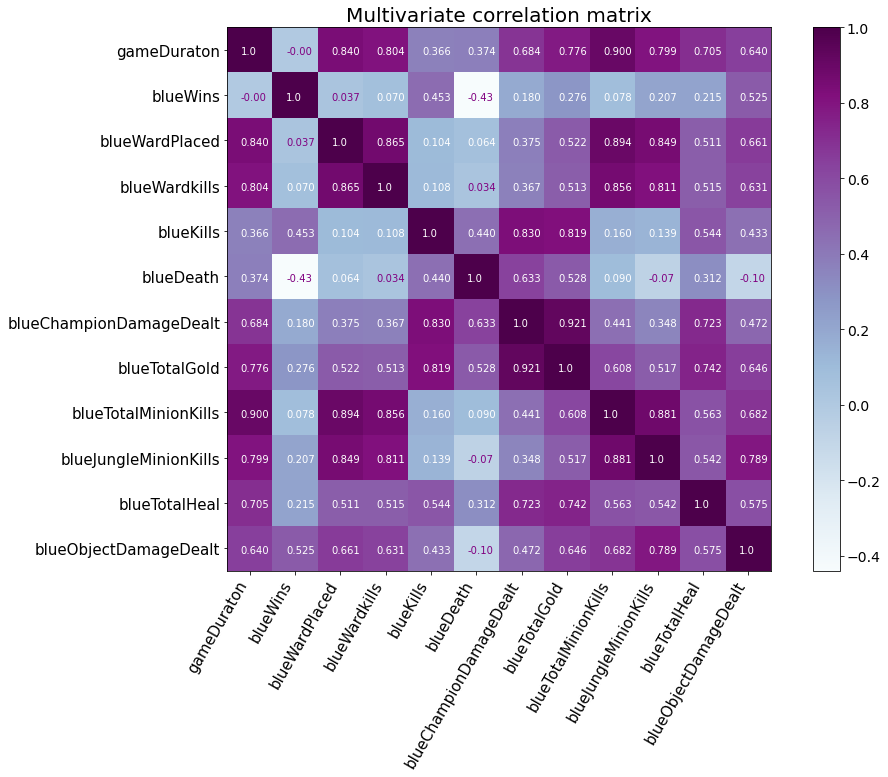

In [10]:
plt.figure(figsize=(15, 10))
corr_m = np.array(source_df.corr())
# print(corr_m)
plt.imshow(corr_m, cmap='BuPu')
ax = plt.subplot()
for i in range(0, 12):
    for j in range(0, 12):
        if corr_m[i,j]<0.05:
                ax.text(-0.2+i, 0.1+j, str(corr_m[i,j])[:5], fontsize = 10, color='purple')
        else:
                ax.text(-0.2+i, 0.1+j, str(corr_m[i,j])[:5], fontsize = 10, color='white')
        # ax.text(0.6, 0.1, str(corr_m[1,0])[:5], fontsize = 20)
# plt.matshow(source_df.corr(), fignum=f.number)
plt.yticks(range(source_df.select_dtypes(['number']).shape[1]), source_df.select_dtypes(['number']).columns, fontsize=15)
plt.xticks(range(source_df.select_dtypes(['number']).shape[1]), source_df.select_dtypes(['number']).columns, fontsize=15, rotation=60, horizontalalignment='right')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Multivariate correlation matrix', fontsize=20)

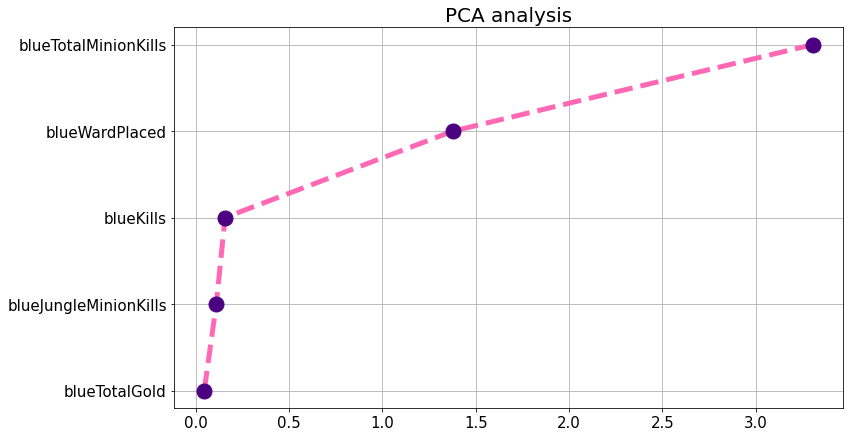

In [11]:
w = ['gameDuraton',
    'blueWardPlaced',
    'blueWardkills', 
    'blueKills', 
    'blueDeath', 
    'blueChampionDamageDealt', 
    'blueTotalGold', 
    'blueTotalMinionKills', 
    'blueJungleMinionKills',
    'blueTotalHeal',
    'blueObjectDamageDealt']
pca_df = source_df[['blueTotalMinionKills', 
                    'blueWardPlaced',
                    'blueKills',                    
                    'blueJungleMinionKills',
                    'blueTotalGold',]]
pca_vars = sk.preprocessing.scale(pca_df)
pca_vars = pd.DataFrame(pca_vars, index=pca_df.index, columns=pca_df.columns)

plt.figure(figsize=(12,7))
pca = PCA().fit(pca_vars)
x = np.std(pca.transform(pca_vars), axis=0)**2
y = - np.arange(len(x)) - 1
plt.plot(x, y, "o", markersize=15, markerfacecolor='indigo', markeredgecolor='indigo', linewidth=5, linestyle='--', color='hotpink')
plt.grid(True)
plt.yticks(y, pca_vars.columns, fontsize=15)
plt.xticks(fontsize=15)
plt.title('PCA analysis', fontsize=20)
plt.show()

## Exercise №6
Build regression model and make an analysis of multicollinearity and regularization (if needed). 

In [24]:
train, test = sk.model_selection.train_test_split (source_df[['gameDuraton', 
                                                            'blueTotalMinionKills', 
                                                            'blueWardPlaced',
                                                            'blueKills',                    
                                                            'blueJungleMinionKills']].copy(), 
                                                                        test_size=0.15, random_state=42)

X_train= train[['blueTotalMinionKills', 'blueWardPlaced', 'blueKills', 'blueJungleMinionKills']]
X_test= test[['blueTotalMinionKills', 'blueWardPlaced', 'blueKills', 'blueJungleMinionKills']]
y_train= train['gameDuraton']
y_test= test['gameDuraton']

random_state=1
table = PrettyTable()
table.field_names = ["Type", "Alpha", "MSE", "VAR", "Coeff"]

lin_r = sk.linear_model.LinearRegression()
lin_r.fit(X_train, y_train)
predicted = lin_r.predict(X_test)
table.add_row(["Least Squares model", "-" , str(sk.metrics.mean_squared_error(y_test, predicted)), str(sk.metrics.r2_score(y_test, predicted)), str(lin_r.coef_)])

l_A = -1
l_MSE = inf
l_var = -1
l_coef = (0, 0, 0, 0)
for alpha in np.arange(0.0,1.001,0.001):
  lin_r = sk.linear_model.Lasso(alpha=alpha, random_state=random_state)
  lin_r.fit(X_train, y_train)
  predicted = lin_r.predict(X_test)
  c_l_MSE = sk.metrics.mean_squared_error(y_test, predicted)
  c_l_var = sk.metrics.r2_score(y_test, predicted)
  c_l_coef = lin_r.coef_
  if c_l_MSE < l_MSE and c_l_var > l_var:
    l_A = alpha
    l_MSE = c_l_MSE
    l_var = c_l_var
    l_coef = c_l_coef

table.add_row(["Best Lasso model", l_A ,str(l_MSE), str(l_var), str(l_coef)])

r_A = -1
r_MSE = inf
r_var = -1
r_coef = (0, 0, 0, 0)
for alpha in np.arange(0.0,1.001,0.001):
  lin_r = sk.linear_model.Ridge(alpha=alpha, random_state=random_state)
  lin_r.fit(X_train, y_train)
  predicted = lin_r.predict(X_test)
  c_r_MSE = sk.metrics.mean_squared_error(y_test, predicted)
  c_r_var = sk.metrics.r2_score(y_test, predicted)
  c_r_coef = lin_r.coef_
  if c_r_MSE < r_MSE and c_r_var > r_var:
    r_A = alpha
    r_MSE = c_r_MSE
    r_var = c_r_var
    r_coef = c_r_coef

table.add_row(["Best Ridge model", r_A ,str(r_MSE), str(r_var), str(r_coef)])

print(table)

/var/folders/7f/v45zg7ms5gzd2qjc6tqr5nwh0000gn/T/ipykernel_13787/1691163236.py:28: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lin_r.fit(X_train, y_train)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.243e+04, tolerance: 1.144e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Rid

+---------------------+-------+-------------------+--------------------+---------------------------------------------------+
|         Type        | Alpha |        MSE        |        VAR         |                       Coeff                       |
+---------------------+-------+-------------------+--------------------+---------------------------------------------------+
| Least Squares model |   -   | 6.458549316187403 | 0.8634718177403731 | [ 0.02757635  0.05211538  0.12925268 -0.00398877] |
|   Best Lasso model  |  0.21 | 6.457948868209418 | 0.8634845106946206 | [ 0.02764219  0.05080485  0.12786313 -0.00351737] |
|   Best Ridge model  |  1.0  | 6.458549298567674 | 0.863471818112839  | [ 0.02757635  0.05211536  0.12925264 -0.00398877] |
+---------------------+-------+-------------------+--------------------+---------------------------------------------------+


## Exercise №7
Analyze the quality of regression model (distribution of residuals, determination coefficient).

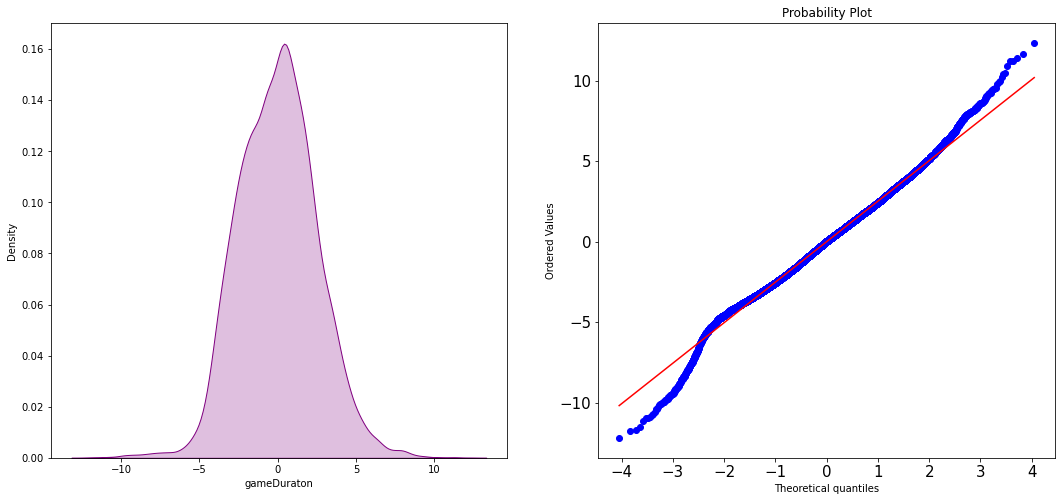

Statistic: 12.608
+------+-------+
|  SL  |   CV  |
+------+-------+
| 15.0 | 0.576 |
| 10.0 | 0.656 |
| 5.0  | 0.787 |
| 2.5  | 0.918 |
| 1.0  | 1.092 |
+------+-------+


In [22]:
model = sk.linear_model.LinearRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

residuals = source_df['gameDuraton'] - model.predict(source_df[['blueTotalMinionKills', 'blueWardPlaced', 'blueKills', 'blueJungleMinionKills']])
residuals.describe()

table = PrettyTable()
table.field_names = ["SL", "CV"]

result = sp.stats.anderson(residuals, dist='norm')
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	table.add_row([sl, cv])

sp.stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.var())) 

fig, axes = plt.subplots(1, 2, figsize=(18, 8))  
sns.kdeplot(residuals, shade=True, color='purple', ax=axes[0])
sp.stats.probplot(residuals, dist="norm", plot=axes[1])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
pylab.show()

print('Statistic: %.3f' % result.statistic)
print(table)